/var/folders/dg/qjq47mdj0rg7svj15wzvmnhr0000gp/T/ipykernel_9912/788635143.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  sysparams.t[:,:] = np.asfortranarray(tfft)
/var/folders/dg/qjq47mdj0rg7svj15wzvmnhr0000gp/T/ipykernel_9912/788635143.py:62: ComplexWarning: Casting complex values to real discards the imaginary part
  sysparams2.t[:,:] = np.asfortranarray(tfft)


[-1.36611876 -0.71667544]
[-0.49535156  0.02840189]
[-0.52928199  0.03130462]
[-0.53794231  0.03227974]
[-0.54012624  0.03255764]
[-0.54068441  0.03263457]
[-0.54083083  0.03265604]
[-0.54087034  0.03266212]
[-0.54088127  0.03266387]
[-0.54088436  0.03266438]
[-0.54088524  0.03266453]
[-0.5408855   0.03266457]
 Calculating initial corresponding KS state
 Properties of initial KS state
 density error   7.3894624223092431E-015
 particle one norm               (1.0000000000000002,0.0000000000000000)
 particle two norm               (1.0000000000000002,0.0000000000000000)
 overlap of one/two               (1.0000000000000002,0.0000000000000000)
 Calculating initial corresponding KS state
 Properties of initial KS state
 density error   7.3894624223092431E-015
 particle one norm               (1.0000000000000002,0.0000000000000000)
 particle two norm               (1.0000000000000002,0.0000000000000000)
 overlap of one/two               (1.0000000000000002,0.0000000000000000)
      fun: 0.0

/Users/jamesbrown/Documents/Coding/TDDFTinversion/python/TDDFTinversion.py:284: ComplexWarning: Casting complex values to real discards the imaginary part
  _TDDFTinversion.f90wrap_systemparameters__set__energy(self._handle, energy)


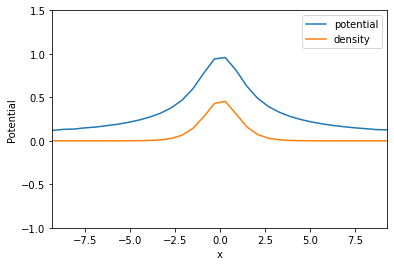

In [1]:
import TDDFTinversion as td
import numpy as np
from scipy.sparse.linalg import eigsh
from scipy.sparse import kron,eye
import matplotlib.pyplot as pl
import matplotlib.animation as manimation
from scipy.optimize import minimize
from copy import copy, deepcopy

addfac = 0.1
np1=2**5 #number of grid points for 1-dimension #remember 65
#initialize systemparameters derived type
sysparams=td.derivedtypes.init_systemparameters(np1)
sysparams.nd=1 #number of dimensions
sysparams.npart=2 #number of particles
sysparams.xmin=-9.3 #minimum grid point
sysparams.xmax=9.3 #maximum grid point
sysparams.triplet=0
sysparams.singlet=1
sysparams.ct=0. #starting time
sysparams.dth=0.012 #goal time step
sysparams.dvksmax=100 #max derivative of density with respect to time
sysparams.pinv0minresqlp1=0 #pseudoinverse set to 0, minresqlp set to 1
sysparams.quantization=1 #Quantization
sysparams.energy=-2.67 #Energy of KS system, this can if desired
td.derivedtypes.fill_systemparameters(sysparams)
td.keomod.buildkeo(sysparams) #build kinetic energy operator and lattice values
#print(sysparams)
#print(sysparams.xlattice)
#exit()

#initialize systemparameters derived type
sysparams2=td.derivedtypes.init_systemparameters(np1)
sysparams2.nd=1 #number of dimensions
sysparams2.npart=2 #number of particles
sysparams2.xmin=-9.3 #minimum grid point
sysparams2.xmax=9.3 #maximum grid point
sysparams2.triplet=0
sysparams2.singlet=1
sysparams2.ct=0. #starting time
sysparams2.dth=0.012 #goal time step
sysparams2.dvksmax=100 #max derivative of density with respect to time
sysparams2.pinv0minresqlp1=0 #pseudoinverse set to 0, minresqlp set to 1
sysparams2.quantization=1 #Quantization
sysparams2.energy=-2.67 #Energy of KS system, this can if desired
td.derivedtypes.fill_systemparameters(sysparams2)
td.keomod.buildkeo(sysparams2) #build kinetic energy operator and lattice values


from scipy.linalg import dft
n_pts = sysparams.np1
dx = sysparams.dx
dp = 2*np.pi/n_pts/dx
p = np.empty(n_pts, dtype=float)
for i in range(n_pts):
    p[i] = dp*i - (n_pts//2)*dp
ptot = np.diag(p**2)
dftmat = dft(n_pts, 'sqrtn')
p2mat= 1/2*np.diag(ptot)
tfft = np.transpose(np.conj(dftmat))@np.diag(p2mat)@dftmat
sysparams.t[:,:] = np.asfortranarray(tfft)
sysparams2.t[:,:] = np.asfortranarray(tfft)

#generate derived type to store 1 and 2 body potentials
sharedvals=td.derivedtypes.init_sharedvalues(sysparams) #shared values derived type

lam_eh = 0.7
lam_ee = 0.6
lam_eli = 2.25

def vpot(xpts, r):
    return -1/np.sqrt((xpts-r/2)**2+lam_eh)-1/np.sqrt((xpts+r/2)**2+lam_eli)

def dvpotr(xpts, r):
    return -(xpts-r/2)/np.sqrt((xpts-r/2)**2+lam_eh)**3/2 + (xpts+r/2)/np.sqrt((xpts+r/2)**2+lam_eli)**3/2

def vinteract(xpts):
    n1=len(xpts)
    fullgrid = np.zeros(n1**2, dtype=float, order="F")
    for n in range(n1):
        fullgrid[n*n1:(n+1)*n1] = 1/np.sqrt(lam_ee+(xpts[n]-xpts)**2)
    return fullgrid

#generate potentials, can write own program
td.potential.generate_1bodypot(sysparams,sharedvals)
td.potential.generate_2bodypot(sysparams,sharedvals)
harm_scale=1.0
sharedvals.vin = 1/2*sysparams.xlattice**2*harm_scale
#print(np.linalg.eigh(sysparams.t+np.diag(sharedvals.vin))[0])
sharedvals.v1[:] = sharedvals.vin[:]
sharedvals.vin[:] = vpot(sysparams.xlattice, 0.25)
sharedvals.v1[:] = sharedvals.vin[:]
sharedvals.vinteract[:] = vinteract(sysparams.xlattice)
#sharedvals.vinteract[:] = 0

error = 1
psi1 = np.zeros(sysparams.np1, dtype=float)
psi2 = np.zeros(sysparams.np1, dtype=float)
ones = np.ones(sysparams.np1, dtype=float)/np.sqrt(sysparams.np1)
vintmat = np.reshape(sharedvals.vinteract, (sysparams.np1,sysparams.np1))

iter = 0
while error > 1.e-12 and iter < 50:
    iter += 1
    dmat = np.kron(psi1,psi1)+np.kron(psi2,psi2)
    density = psi1*psi1+psi2*psi2
    exchange = np.reshape(dmat*sharedvals.vinteract, (sysparams.np1,sysparams.np1))
    coulomb = np.diag(np.matmul(vintmat,density))
    fock = np.diag(sharedvals.vin) + sysparams.t + 1*coulomb - 1/2*exchange
    
    e,psinew = eigsh(fock, k=2, which='SA')
    print(e)
    error = 2-(np.abs(psi1.dot(psinew[:,0]))+np.abs(psi2.dot(psinew[:,0])))
    psi1=psinew[:,0]
    psi2=psinew[:,0]

sharedvals.v1 = sharedvals.vin + 1/2*np.diag(coulomb) #- np.diag(exchange)/2
#sharedvals.v1[:] = sharedvals.vin[:]
other = np.diag(sharedvals.v1) + sysparams.t# + 2*coulomb - 1*np.diag(np.diag(exchange))
#pl.plot(np.diag(coulomb)-1/2*np.diag(exchange))
e,psinew = eigsh(other, k=2, which='SA')
sysparams.energy=np.sum(e)
sysparams2.energy = np.sum(e)
psi1 = psinew[:, 0]
psi2 = psinew[:, 0]
#print(e)



#derived type that stores full wavefunction and potential
fullvals=td.derivedtypes.init_fullvalues(sysparams)
#td.potential.generate_nbodypot(sysparams,sharedvals,fullvals)
#td.initial_states.initializefullsystem(sysparams,fullvals)
fullvals.psi[:] = (np.kron(psi1, psi2))#-np.kron(psi2, psi1)).astype(np.complex128)
fullvals.psi /= np.linalg.norm(fullvals.psi)
#exit()
ones = np.array([0*i+1 for i in range(np1)]).astype(np.float64)
fullvals.v[:] = np.kron(sharedvals.v1, ones) + np.kron(ones, sharedvals.v1)

#next 5 are required to develop and advance KS orbitals
dpe=np.zeros(sysparams.ntot1,dtype=np.float64) #current density
dnx=np.zeros(sysparams.ntot1,dtype=np.float64) #current derivative of density
ddnx=np.zeros(sysparams.ntot1,dtype=np.float64) #second derivative of density
dpenew=np.zeros(sysparams.ntot1,dtype=np.float64) #density after time step dt, taken from sysparams.dt
ddnxnew=np.zeros(sysparams.ntot1,dtype=np.float64) #second derivative of density after time step sysparams.dt

#placeholder for advancing full system
psinew=np.zeros(sysparams.ntot,dtype=np.complex128)


td.density.fullwf_density(sysparams,fullvals.psi,dpe)

#initialize KS orbitals system to match dpe
KSvals=td.initial_states.initializekssystem(sysparams,sharedvals,dpe,cutoff=0.0001)
KSvals.vks = sharedvals.v1[:]
KSvals2=td.initial_states.initializekssystem(sysparams,sharedvals,dpe,cutoff=0.001)
KSvals2.vks = sharedvals.v1[:]

np1 = sysparams.np1


vin = np.kron(sharedvals.vin, ones) + np.kron(ones, sharedvals.vin)
vinit = np.kron(sharedvals.v1, ones)+ np.kron(ones,sharedvals.v1) - vin
vfin = sharedvals.vinteract
KSvals.phi[:,0] = psi1
KSvals.phi[:,1] = psi2
KSvals.vks[:] = sharedvals.v1[:]
#print(KSvals.vks[:] - sharedvals.v1)
#exit()
sharedvals.v1[:] = sharedvals.vin

def adiapot(t):
    b = 0.15
    a = 22
    func = 1/(1+np.exp(-b*(t-a)))
    dfunc = b*np.exp(-b*(t-a))/((1+np.exp(-b*(t-a)))**2)
    pot = (1-func)*vinit + func*vfin
    dpot = -dfunc*vinit + dfunc*vfin
    return pot, dpot
sharedvals.vin[:] = 1/2*sysparams.xlattice**2*harm_scale
sharedvals.v1[:] = sharedvals.vin[:]
sharedvals.vin[:] = vpot(sysparams.xlattice, 0.25)*0
sharedvals.v1[:] = vpot(sysparams.xlattice, 0.25) #sharedvals.vin[:]
#KSvals.vks = KSvals.vks - sharedvals.v1
vks, dvks = adiapot(sysparams.ct)
vksnew, dvksnew = adiapot(sysparams.ct+sysparams.dt)

vin = np.kron(np.ones(np1), sharedvals.v1)+np.kron(sharedvals.v1, np.ones(np1))+sharedvals.vinteract
    
sysparams.dt=sysparams.dth

t2 = kron(sysparams.t, eye(sysparams.np1))+kron(eye(sysparams.np1),sysparams.t)

sysparams.energy = np.dot(fullvals.psi.conj(), t2.dot(fullvals.psi) + (vin+vks)*fullvals.psi).real
goales,waves = eigsh(t2+np.diag(vin), k=2, which='SA')
goale = goales[0:1]
wave = waves[:,0:1]

one_rdm = np.zeros((sysparams.ntot1, sysparams.ntot1), dtype=np.float64, order="F")
td.density.fullwf_density_matrix(sysparams, wave[:,0], one_rdm)
goal_d = np.diag(one_rdm)
def func(vp, t, rdm):
    first_part = np.trace(np.matmul(t + np.diag(vp/np.sqrt(np.diag(rdm))), rdm))
    e, phi = eigsh(t + np.diag(vp/np.sqrt(np.diag(rdm))), k=2, which='SA')
    return first_part - e[0]-e[0]
def jac(vp, t, rdm):
    jacvals = np.zeros(len(vp))
    e, phi = eigsh(t + np.diag(vp/np.sqrt(np.diag(rdm))), k=2, which='SA')
    for i, v in enumerate(vp):
        jacvals[i] = rdm[i,i]/np.sqrt(rdm[i,i])
        jacvals[i] -= (phi[i,0]**2+phi[i,0]**2)/np.sqrt(rdm[i,i])
    return jacvals
vpar = KSvals.vks.copy()*np.sqrt(np.diag(one_rdm))
result = minimize(func, vpar, args=(sysparams.t, one_rdm), jac=jac, method="L-BFGS-B", tol=1.e-14, options={"disp": False, "maxiter": 1000, "gtol": 1e-9})
print(result)
print(vpar)

e, phi = eigsh(sysparams.t + np.diag(result.x/np.sqrt(np.diag(one_rdm))), k=2, which="SA")
print(np.linalg.norm((phi[:,0]*phi[:,0]+phi[:,0]*phi[:,0]).flatten().real-goal_d))
print(2*np.dot(phi[:,0],sysparams.t@phi[:,0]+sharedvals.v1*phi[:,0])+0*np.dot(phi[:,0]*phi[:,0],vintmat@(phi[:,0]*phi[:,0]))-goale)
exc = 2*np.dot(phi[:,0],sysparams.t@phi[:,0]+sharedvals.v1*phi[:,0])+0*np.dot(phi[:,0]*phi[:,0],vintmat@(phi[:,0]*phi[:,0]))-goale

KSvals.vks = result.x/np.sqrt(np.diag(one_rdm))#+sharedvals.v1
KSvals.phi[:,0] = phi[:,0]
KSvals.phi[:,1] = phi[:,0]

#pl.plot(np.diag(one_rdm))
#pl.show()
#exit()
ri = 0.25
rf = 0.5
vext_start1 = vpot(sysparams.xlattice, ri)
vext_final1 = vpot(sysparams.xlattice, rf)

vext_start = np.kron(vext_start1, np.ones(np1))+np.kron(np.ones(np1), vext_start1)
vext_final = np.kron(vext_final1, np.ones(np1))+np.kron(np.ones(np1), vext_final1)

vinit = sharedvals.vinteract + vext_start
vfin = sharedvals.vinteract + vext_final # addfac*vin
n_steps = 2500
ttime = n_steps*sysparams.dt



def adiapot(t):
    b = 0.25
    a = 30
    #func = 1/(1+np.exp(-b*(t-a)))
    #dfunc = b*np.exp(-b*(t-a))/((1+np.exp(-b*(t-a)))**2)
    #func = np.sin(np.pi/2*t/(0.012*5000))
    #dfunc = np.pi/2/(0.012*5000)*np.cos(np.pi/2*t/(0.012*5000))
    func = (1-np.cos(np.pi*t/(ttime)))/2
    dfunc = np.pi/2/(ttime)*np.sin(np.pi*t/(ttime))
    th = t/ttime
    print("th", t, th)
    func = 6*th**5-15*th**4+10*th**3
    dfunc = (6*5*th**4-15*4*th**3+10*3*th**2)/ttime
    func = -20*th**7 + 70*th**6 - 84*th**5 + 35*th**4
    dfunc = (-20*7*th**6 + 70*6*th**5 - 84*5*th**4 + 35*4*th**3)/ttime
    #func = 70*th**9 -315*th**8 + 540*th**7 - 420*th**6 + 126*th**5
    #dfunc = (70*9*th**8 -315*8*th**7 + 540*7*th**6 - 420*6*th**5 + 126*5*th**4)/ttime
    #tval = np.tan((2*th-1)*np.pi/4)
    #ttval = (1+tval)/2
    #sval = 1/np.cos((2*th-1)*np.pi/4)
    #func = 6*ttval**5-15*ttval**4+10*ttval**3
    #dfunc = 15*np.pi/32/ttime*(tval**2-1)**2*sval**2
    pot = (1-func)*vinit + func*vfin
    dpot = -dfunc*vinit + dfunc*vfin
    cr = func*(rf-ri)+ri
    print('cr')
    vext1 = vpot(sysparams.xlattice, cr)
    vext2 = np.kron(vext1, np.ones(np1))+np.kron(np.ones(np1), vext1)
    vext1d = dvpotr(sysparams.xlattice, cr)*dfunc*(rf-ri)
    pot = sharedvals.vinteract + vext2
    dpot = np.kron(vext1d, np.ones(np1))+np.kron(np.ones(np1), vext1d)

    #if t < ttime/2:
    #    func = (1-np.cos(np.pi*t/(ttime/2)))/2
    #    dfunc = np.pi/2/(ttime/2)*np.sin(np.pi*t/(ttime/2))
    #    pot = (1-func)*vinit + func*vmid
    #    dpot = -dfunc*vinit + dfunc*vmid
    #else:
    #    func = (1-np.cos(np.pi*(t-ttime/2)/(ttime/2)))/2
    #    dfunc = np.pi/2/(ttime/2)*np.sin(np.pi*(t-ttime/2)/(ttime/2))
    #    pot = (1-func)*vmid + func*vfin
    #    dpot = -dfunc*vmid + dfunc*vfin
    return pot, dpot

def adiapot1(t):
    b = 0.25
    a = 30
    #func = 1/(1+np.exp(-b*(t-a)))
    #dfunc = b*np.exp(-b*(t-a))/((1+np.exp(-b*(t-a)))**2)
    #func = np.sin(np.pi/2*t/(0.012*5000))
    #dfunc = np.pi/2/(0.012*5000)*np.cos(np.pi/2*t/(0.012*5000))
    func = (1-np.cos(np.pi*t/(ttime)))/2
    dfunc = np.pi/2/(ttime)*np.sin(np.pi*t/(ttime))
    th = t/ttime
    func = 6*th**5-15*th**4+10*th**3
    dfunc = (6*5*th**4-15*4*th**3+10*3*th**2)/ttime
    func = -20*th**7 + 70*th**6 - 84*th**5 + 35*th**4
    dfunc = (-20*7*th**6 + 70*6*th**5 - 84*5*th**4 + 35*4*th**3)/ttime
    #func = 70*th**9 -315*th**8 + 540*th**7 - 420*th**6 + 126*th**5
    #dfunc = (70*9*th**8 -315*8*th**7 + 540*7*th**6 - 420*6*th**5 + 126*5*th**4)/ttime
    #tval = np.tan((2*th-1)*np.pi/4)
    #ttval = (1+tval)/2
    #sval = 1/np.cos((2*th-1)*np.pi/4)
    #func = 6*ttval**5-15*ttval**4+10*ttval**3
    #dfunc = 15*np.pi/32/ttime*(tval**2-1)**2*sval**2
    pot = (1-func)*vext_start1 + func*vext_final1
    dpot = -dfunc*vext_start1 + dfunc*vext_final1
    cr = func*(rf-ri)+ri
    vext1 = vpot(sysparams.xlattice, cr)
    pot = vext1
    dpot = dvpotr(sysparams.xlattice, cr)*dfunc*(rf-ri)
    #if t < ttime/2:
    #    func = (1-np.cos(np.pi*t/(ttime/2)))/2
    #    dfunc = np.pi/2/(ttime/2)*np.sin(np.pi*t/(ttime/2))
    #    pot = (1-func)*vext_start1 + func*vext_mid1
    #    dpot = -dfunc*vext_start1 + dfunc*vext_mid1
    #else:
    #    func = (1-np.cos(np.pi*(t-ttime/2)/(ttime/2)))/2
    #    dfunc = np.pi/2/(ttime/2)*np.sin(np.pi*(t-ttime/2)/(ttime/2))
    #    pot = (1-func)*vext_mid1 + func*vext_final1
    #    dpot = -dfunc*vext_mid1 + dfunc*vext_final1
    return pot, dpot


vks, dvks = adiapot(sysparams.ct)
vksnew, dvksnew = adiapot(sysparams.ct+sysparams.dt)

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Kohn-Sham Potential during adiabatic evolution', artist='Matplotlib',
                comment='a red circle following a blue sine wave')
writer = FFMpegWriter(fps=15, metadata=metadata)
vin = np.kron(np.ones(np1), sharedvals.vin)+np.kron(sharedvals.vin, np.ones(np1))
fig = pl.figure()
ax1 = pl.axes(xlim = (-9.3, 9.3), ylim = (-1, 1.5))
absfig, = ax1.plot(sysparams.xlattice, KSvals.vks-sharedvals.v1, label="potential")
absfig2, = ax1.plot(sysparams.xlattice, goal_d, label='density')
ax1.legend()
pl.xlabel('x')
pl.ylabel('Potential')
plotlays, plotcols = [2], ["black", "red"]
#lines = []
funcvals = np.zeros(n_steps+1)
densities = np.zeros((n_steps+1, sysparams.np1))
ddensities = np.zeros((n_steps+1, sysparams.np1))
dddensities = np.zeros((n_steps+1, sysparams.np1))
energies = np.zeros(n_steps+1)
potentials = np.zeros((n_steps+1, sysparams.np1))
exacte = np.zeros(n_steps+1)
#for index in range(2):
#    lobj = ax1.plot([], [], color=plotcols[index][0])
#    lines.append(lobj)
#pl.ylim((-1.,3.5))
fsum = 0.
fullvals.psi = waves[:, 0]
sysparams.energy = np.dot(fullvals.psi.conj(), t2.dot(fullvals.psi) + (vin+vks)*fullvals.psi).real #-fsum/sysparams.dx*10
sysparams.energy = 2*np.vdot(KSvals.phi[:,0],sysparams.t@KSvals.phi[:,0]+vext_start1*KSvals.phi[:,0])+fsum
exacte[0] = eigsh(t2+np.diag(vin+vks), k=1, which='SA')[0][0]
energies[0] = sysparams.energy-exc

In [2]:
import pandas as pd
densities = pd.read_csv('dens.csv')
ddensities = pd.read_csv('ddens.csv')
dddensities = pd.read_csv('dddens.csv')
densities = densities.T
ddensities = ddensities.T
dddensities = dddensities.T

In [3]:
from scipy import interpolate
import numpy as np
rng = np.random.default_rng()
times_qc = pd.read_csv('times_qc.csv')
dens_qc = pd.read_csv('dens_qc.csv')
tcks = []
for i in range(n_pts):
    tcks.append(interpolate.splrep(times_qc["0"].to_numpy(), dens_qc[str(i)].to_numpy(), k=4))
xnew = times_qc["0"]
ynew = interpolate.splev(xnew, tcks[16], der=0)
interpolate.splev(0.1, tcks[16])

array(0.2268875)

In [4]:
def calc_dens(time):
    dens = np.zeros(n_pts)
    for i in range(n_pts):
        dens[i] = interpolate.splev(time, tcks[i], der=0)
    return dens*2

def calc_ddens(time):
    dens = np.zeros(n_pts)
    for i in range(n_pts):
        dens[i] = interpolate.splev(time, tcks[i], der=1)
    return dens*2

def calc_dddens(time):
    dens = np.zeros(n_pts)
    for i in range(n_pts):
        dens[i] = interpolate.splev(time, tcks[i], der=2)
    return dens*2


In [5]:
with writer.saving(fig, "potential.mp4", 100):
    for loop in range(n_steps+1):
        print('\n')
        print('For time '+str(sysparams.ct)+' to ',str(sysparams.ct+sysparams.dt), 'ttime', ttime)
        vks, dvks = adiapot(sysparams.ct)
        vksnew, dvksnew = adiapot(sysparams.ct+sysparams.dt)

        # generate wavefunction at ct+dt
        #td.propagate.advancewf(sysparams,sharedvals,25,vin+vks,fullvals.psi,psinew)
        #td.propagate.advancewftd(sysparams,sharedvals,15,vin,vks,vksnew,fullvals.psi, psinew,dvks,dvksnew)

        # Calculate new energy
         #np.dot(psinew.conj(), t2.dot(psinew) + (vin+vksnew)*psinew).real #-fsum/sysparams.dx*10
        #sysparams.energynew = np.dot(psinew.conj(), t2.dot(psinew) + (vin+vksnew)*psinew).real #-fsum/sysparams.dx*10
        #print(sysparams.energynew-goale, sysparams.energynew, sysparams.energy)
        
        print(np.linalg.norm(psinew), 'norm full')

        
        #Calculate density, first derivative of density and second derivative of density 
        #at time ct using psi
        #td.density.fullwf_density(sysparams,fullvals.psi,dpe)
        #td.density.calcdnx(sysparams,sharedvals,sysparams.ntot1,fullvals.psi,vin+vks,dnx)
        #td.density.calcddnx(sysparams,sharedvals,sysparams.ntot1,fullvals.psi,vin+vks,ddnx)

        pos = round(sysparams.ct/sysparams.dt)
        #dpe = densities[pos][1:].to_numpy() 
        #dnx = ddensities[pos][1:].to_numpy()
        #ddnx = dddensities[pos][1:].to_numpy()
        dpe = calc_dens(sysparams.ct)
        dnx = calc_ddens(sysparams.ct)
        ddnx = calc_dddens(sysparams.ct)
        
    
        #Calculate density and second derivative of density at time ct+dt using psinew
        #td.density.fullwf_density(sysparams,psinew,dpenew)
        #td.density.calcddnx(sysparams,sharedvals,sysparams.ntot1,psinew,vin+vksnew,ddnxnew)

        pos = round((sysparams.ct+sysparams.dt)/sysparams.dt)
        #dpenew = densities[pos][1:].to_numpy()
        #ddnxnew = dddensities[pos][1:].to_numpy()
        dpenew = calc_dens(sysparams.ct+sysparams.dt)
        ddnxnew = calc_dddens(sysparams.ct+sysparams.dt)

        # Reset energy
        v1cur = adiapot1(sysparams.ct)[0]
        fsum += sysparams.dt*np.dot(dnx, KSvals.vks-v1cur)
        sysparams.energynew = 2*np.vdot(KSvals.phi[:,0],sysparams.t@KSvals.phi[:,0]+(v1cur)*KSvals.phi[:,0]).real+fsum
        
        #vblah = copy(KSvals.vks)
        #Attempt to advance KS system
        info=td.propagate.advancekssystem(dpe,dpenew,dnx,ddnx,ddnxnew,sysparams,KSvals,sharedvals)
        #sysparams.energynew = 2*np.vdot(KSvals.phi[:,0],sysparams.t@KSvals.phi[:,0]+(v1cur)*KSvals.phi[:,0]).real+fsum
        energies[pos] =  2*np.vdot(KSvals.phi[:,0],sysparams.t@KSvals.phi[:,0]+(v1cur)*KSvals.phi[:,0]).real+fsum-exc
        potentials[pos] = KSvals.vks.copy()
        #info2 = td.propagate.advancekssystem(dpenew,dpenew,dnx*0,ddnx*0,ddnxnew*0,sysparams2,KSvals2,sharedvals)
        #potentials[pos] = KSvals2.vks.copy()
        #td.propagate.shift_phases(np1, 1, np1, 2, sysparams.t, dnx*0, KSvals2.phi)
        #td.propagate.calculate_vks(20, np1, 1, np1, 2, sysparams.t, sysparams2.pinv0minresqlp1, ddnx*0, KSvals2.phi, KSvals2.vks)
        
        print('fsum', fsum)
        #print(KSvals.vks-vblah)
        #exit()
        if (info==1):#succesful advance of orbitals shift full wavefunction
            fullvals.psi=psinew
            sysparams.energy = copy(sysparams.energynew)
        elif loop > 0:
            exit()
        if loop%50 == 0:
            absfig.set_data(sysparams.xlattice, KSvals.vks-v1cur)
            absfig2.set_data(sysparams.xlattice, dpenew)
            writer.grab_frame()



For time 0.0 to  0.012 ttime 30.0
th 0.0 0.0
cr
th 0.012 0.0004
cr
0.0 norm full
 Assigning phases
 Initial phases error   6.5927761776962620E-007
fsum Final phases error   9.3764043009882840E-017
 Starting advance of KS orbitals
     iteration difference =  1.1476676441E-14
     iteration difference =  1.0633946800E-23
     iteration difference =  1.1129677379E-32
     iteration difference =  1.7936620343E-43
 Orbitals converged, recalculate potential
     iteration difference =  1.6471451229E-17
 Potential Converged
     iteration difference =  4.2322647431E-27
     iteration difference =  2.0709008416E-36
 Orbitals and potential converged, Time step complete
 restart with dvks saved
 Density error for time step 1 = 1.3265923723E-07
 Check properties of orbitals
 Particle number   2.0000000000000004     
 Overlap Integral   1.0000000000000002     
 Overlap matrix
  1.00E+00  1.00E+00
  1.00E+00  1.00E+00
 3.3211087839031442e-09


For time 0.0 to  0.012 ttime 30.0
th 0.0 0.0
cr
th 0

In [6]:
dnx = calc_dens(30.)
v1cur = adiapot1(ttime)[0]
fsum += sysparams.dt*np.dot(dnx, KSvals.vks-v1cur)/2
print('fsum', fsum)
vin = np.kron(sharedvals.vin, ones) + np.kron(ones, sharedvals.vin)
goalf,wavesf = eigsh(t2+np.diag(vfin), k=2, which='SA')
goali,wavesi = eigsh(t2+np.diag(vinit), k=2, which='SA')
print('goal diff', goalf[0]-goali[0])
KSvals2.phi = KSvals.phi.copy()
td.density.fullwf_density(sysparams,wavesf[:,0],dpenew)
td.propagate.shift_phases(np1, 1, np1, 2, sysparams.t, dnx*0, KSvals2.phi)
td.propagate.calculate_vks(20, np1, 1, np1, 2, sysparams.t, sysparams2.pinv0minresqlp1, ddnx*0, KSvals2.phi, KSvals2.vks)
E, V = np.linalg.eigh(sysparams.t+np.diag(KSvals.vks))
print(np.linalg.norm(dpenew-V[:,0]**2-V[:,0]**2))
E, V = np.linalg.eigh(sysparams.t+np.diag(KSvals2.vks))
print(np.linalg.norm(dpenew-V[:,0]**2-V[:,0]**2))
print(E[0]*2)
print('over', np.abs(np.dot(wavesf[:,0], psinew)))
goales,waves = eigsh(t2+np.diag(vin+vksnew), k=2, which='SA')
print(goales)
print(goalf)
print(2*np.dot(V[:,0],sysparams.t@V[:,0]+vext_final1*V[:,0])-goales[0]-exc-fsum)
print(2*np.dot(V[:,0],sysparams.t@V[:,0]+vext_final1*V[:,0])-goales[0]-exc+fsum)
print(2*np.dot(V[:,0],sysparams.t@V[:,0]+vext_final1*V[:,0])-goales[0]-exc+fsum)

fsum -0.0062664702831509555
goal diff 0.013562975323609505
 Assigning phases
 Initial phases error   5.0752095390703504E-006
 Final phases error   3.2822953642002681E-017
0.0005324917437614378
0.0005385902091652711
0.12416141200199568
over 0.0
[-1.90659763 -1.63733315]
[-1.90659763 -1.63733315]
[0.01249621]
[-3.67267128e-05]
[-3.67267128e-05]


In [7]:
de = pd.DataFrame(energies)
dvks = pd.DataFrame(potentials)

de.to_csv('ener_qc.csv')
dvks.to_csv('vks_qc.csv')